In [1]:
# 挂载 google 云盘
from google.colab import drive
drive.mount('/content/gdrive')

# 将文件路径指定为数据路径
import os
os.chdir('/content/gdrive/My Drive/comment')

# 第一次使用该语句可下载词向量数据集压缩包，其后可忽略，
# !wget https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip
# 解压缩
# !unzip 'wiki-news-300d-1M.vec.zip'

# 导入必要的库

# 计算库
import numpy as np
import pandas as pd

from tqdm import tqdm #显示运行进度条
import io

# 画图库
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sb
import matplotlib.pyplot as plt

# 文字处理库
from keras.preprocessing.text import Tokenizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
nltk.download('stopwords') #下载停止词
import string
from keras.preprocessing import sequence
from keras.preprocessing.text import text_to_word_sequence

# 深度学习库
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, Dropout, Dense, SpatialDropout1D, BatchNormalization, Activation
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, MaxPooling1D, AveragePooling1D
from keras import optimizers, metrics, Model
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.layers.advanced_activations import LeakyReLU
# from keras.layers import LSTM,Bidirectional, GRU
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Concatenate, Input, Bidirectional

# 随机种子
import random
random.seed(0)

import pickle
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
from keras.models import Model
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback, EarlyStopping
from keras.layers import Embedding, Conv1D, Dropout, Dense, SpatialDropout1D, BatchNormalization, Activation
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, MaxPooling1D, AveragePooling1D
from keras import optimizers, metrics, Model
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers import Concatenate, Input, Flatten
from keras.utils import plot_model
from sklearn.metrics import roc_curve,auc,roc_auc_score
from keras.callbacks import Callback
from keras import initializers
from tqdm import tqdm
import io
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sb
import matplotlib.pyplot as plt

# 文字处理库
from keras.preprocessing.text import Tokenizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
nltk.download('stopwords') #下载停止词
import string
from keras.preprocessing import sequence
from keras.preprocessing.text import text_to_word_sequence


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 200, 300)     30000000    input_3[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, 200, 300)     0           embedding_3[0][0]                
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 200, 256)     330240      spatial_dropout1d_3[0][0]        
__________________________________________________________________________________________________
bidirectio

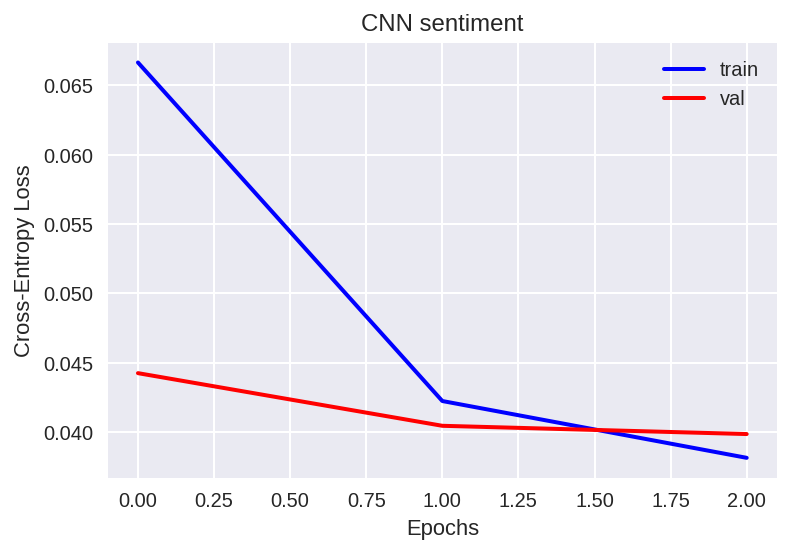

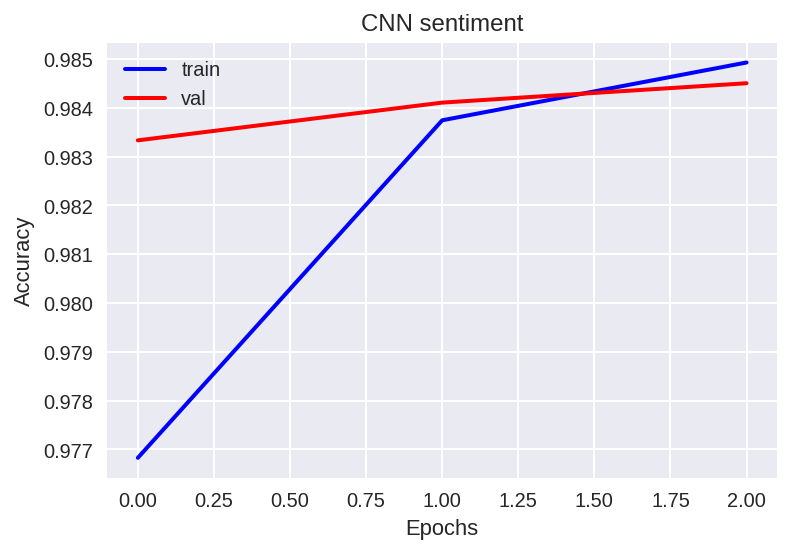

final score is 0.9840


In [4]:
from keras.layers import CuDNNGRU, CuDNNLSTM 

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
# pickle.dump({'strain': seq_train, 'stest': seq_test, 'fm':feature_matrix}, open('/content/gdrive/My Drive/comment/var.txt', 'wb'))
var = pickle.load(open('/content/gdrive/My Drive/comment/varibles.txt', 'rb'))
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
x_train = var['xtrain']
x_test = var['xtest']
embedding_matrix = var['em']
y_train = var['ytrain']



class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))
            
            
            

word_upper = 100000
word_features = 300
maxlen = 200


inp = Input(shape=(maxlen, ))

x = Embedding(word_upper, 
              word_features, 
              weights=[embedding_matrix],
              trainable=True)(inp)

x0 = SpatialDropout1D(0.5)(x)



#--------------------

x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x0)
y = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x0)

avg_poolx = GlobalAveragePooling1D()(x)
max_poolx = GlobalMaxPooling1D()(x)

avg_pooly = GlobalAveragePooling1D()(y)
max_pooly = GlobalMaxPooling1D()(y)


conc = Concatenate(axis=1)([avg_poolx, max_poolx, 
                            avg_pooly, max_pooly])


#-------------------------------------
##Bi-GRU-CNN-Poolings

# x = Bidirectional(CuDNNGRU(128, return_sequences = True))(x)
# x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
# avg_pool = GlobalAveragePooling1D()(x)
# max_pool = GlobalMaxPooling1D()(x)
# x = Concatenate(axis=1)([avg_pool, max_pool])
#-------------------------------------

# x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
# x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
# avg_pool = GlobalAveragePooling1D()(x)
# max_pool = GlobalMaxPooling1D()(x)
# conc = Concatenate(axis=1)([avg_pool, max_pool])

#------------------------------------------------------

conc = Dropout(0.1)(conc)
outp = Dense(6, kernel_initializer=initializers.RandomNormal(), activation="sigmoid")(conc)

model = Model(inputs=inp, outputs=outp)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


batch_size = 256 # not 64
epochs = 10

X_tra, X_val, y_tra, y_val = train_test_split(x_train, 
                                              y_train, 
                                              test_size=0.1, 
                                              shuffle=True)

RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

early = EarlyStopping(monitor='val_acc', 
                      min_delta=0.01, 
                      patience=2, 
                      verbose=1)

callback_list = [RocAuc, early]


hist = model.fit(X_tra, y_tra, 
                 batch_size=batch_size, 
                 epochs=epochs, 
                 validation_data=(X_val, y_val),
                 callbacks=callback_list, 
                 verbose=1,
                 shuffle=True,
                 class_weight='balanced')



plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

y_pred = model.predict(x_test, batch_size=1024)
submission = pd.read_csv('sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
# submission.to_csv('CNN.csv', index=False)
test_labels = pd.read_csv('test_labels.csv')
real_test = test_labels[test_labels['toxic']>=0]
score = roc_auc_score(real_test[labels], submission.iloc[real_test.index][labels])
print('final score is {:.4f}'.format(score))

In [0]:
submission.to_csv('GRU.csv', index=False)